In [34]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [35]:
# Chúng ta dùng các giá trị chuẩn hóa của MNIST như trong ví dụ
transform = transforms.Compose([
    transforms.ToTensor(), # Dòng 5
    transforms.Normalize((0.1307,), (0.3081,)) 
])

# Load FashionMNIST dataset 
train_dataset = datasets.FashionMNIST(root='./data', train=True, 
                                      download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, 
                                     download=True, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Lấy số lượng lớp (10) và kích thước ảnh (28*28)
num_classes = len(train_dataset.classes)
input_size = 28 * 28 # FashionMNIST là 28x28 pixels
print(f"Đã tải FashionMNIST: num_classes = {num_classes}, input_size = {input_size}")
# Thêm thiết lập 'device'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

Đã tải FashionMNIST: num_classes = 10, input_size = 784
Sử dụng thiết bị: cuda


In [36]:
import torch.nn as nn
import torch.nn.functional as F

In [37]:
class SimpleDNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Làm phẳng ảnh 28x28 thành vector 784
        # batch_size, 1, 28, 28 -> batch_size, 784
        x = x.view(-1, 28*28) 
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [38]:
import torch.optim as optim

In [39]:
# 1. Khởi tạo Mô hình 
hidden_size = 50 # Dòng 19
model = SimpleDNN(input_size, hidden_size, num_classes).to(device)
# Chọn Loss Function 
criterion = nn.CrossEntropyLoss()
# Chọn Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Đã khởi tạo Model, Criterion, và Optimizer.")

Đã khởi tạo Model, Criterion, và Optimizer.


In [42]:

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted_labels = torch.max(outputs.data, 1) 
            total_samples += labels.size(0) # Dòng 18
            correct_predictions += (predicted_labels == labels).sum().item() 

    avg_loss = total_loss / len(dataloader) 
    accuracy = 100 * correct_predictions / total_samples 
    
    model.train() # đặt lại model về train mode
    
    return avg_loss, accuracy

In [43]:

num_epochs = 10 

print("Bắt đầu huấn luyện...")

for epoch in range(num_epochs): 
    model.train() 
    
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        
        # 1. Move data to device
        data = data.to(device)
        labels = labels.to(device)
        
        # 2. Zero gradients 
        optimizer.zero_grad()
        
        # 3. Forward Pass 
        outputs = model(data)
        
        # 4. Calculate Loss
        loss = criterion(outputs, labels)
        
        # 5. Backward Pass 
        loss.backward()
        
        # 6. Optimization Step 
        optimizer.step()
        
        # Print training statistics
        if (batch_idx + 1) % 100 == 0: # In mỗi 100 batch 
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')
    
    val_loss, val_accuracy = validate(model, test_dataloader, criterion, device)
    print(f'*** Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}% ***')

print("Training finished!") # Dòng 29

Bắt đầu huấn luyện...
Epoch [1/10], Batch [100/938], Loss: 0.6338
Epoch [1/10], Batch [200/938], Loss: 0.5235
Epoch [1/10], Batch [300/938], Loss: 0.5057
Epoch [1/10], Batch [400/938], Loss: 0.5370
Epoch [1/10], Batch [500/938], Loss: 0.3791
Epoch [1/10], Batch [600/938], Loss: 0.4609
Epoch [1/10], Batch [700/938], Loss: 0.6677
Epoch [1/10], Batch [800/938], Loss: 0.3949
Epoch [1/10], Batch [900/938], Loss: 0.2702
*** Epoch [1/10], Validation Loss: 0.4267, Validation Accuracy: 84.68% ***
Epoch [2/10], Batch [100/938], Loss: 0.2568
Epoch [2/10], Batch [200/938], Loss: 0.3134
Epoch [2/10], Batch [300/938], Loss: 0.3110
Epoch [2/10], Batch [400/938], Loss: 0.3185
Epoch [2/10], Batch [500/938], Loss: 0.4291
Epoch [2/10], Batch [600/938], Loss: 0.4171
Epoch [2/10], Batch [700/938], Loss: 0.4215
Epoch [2/10], Batch [800/938], Loss: 0.5815
Epoch [2/10], Batch [900/938], Loss: 0.2665
*** Epoch [2/10], Validation Loss: 0.4204, Validation Accuracy: 84.94% ***
Epoch [3/10], Batch [100/938], Loss:

In [45]:
# Lưu model
torch.save(model.state_dict(), 'mlp_fashionmnist.pth')
print("Đã lưu model state dict vào 'mlp_fashionmnist.pth'")

Đã lưu model state dict vào 'mlp_fashionmnist.pth'


In [46]:
loaded_model = SimpleDNN(input_size, hidden_size, num_classes).to(device)
loaded_model.load_state_dict(torch.load('mlp_fashionmnist.pth'))
loaded_model.eval()

print("Đã tải model đã lưu.")

# Kiểm tra nhanh
test_loss, test_acc = validate(loaded_model, test_dataloader, criterion, device)
print(f'Kiểm tra mô hình đã tải - Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%')

Đã tải model đã lưu.
Kiểm tra mô hình đã tải - Loss: 0.3531, Accuracy: 88.00%


Một số ảnh trong tập huấn luyện:


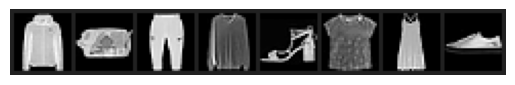

Nhãn: Coat  | Bag   | Trouser | Pullover | Sandal | T-shirt/top | Dress | Sneaker


In [49]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Định nghĩa tên các lớp của FashionMNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 2. Hàm để hiển thị ảnh (un-normalize)
def imshow(img):
    # Un-normalize (từ slide gốc MNIST)
    img = img * 0.3081 + 0.1307 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off') # Ẩn trục tọa độ
    plt.show()

# 3. Lấy một batch ảnh huấn luyện
# iter(train_dataloader).next() sẽ bị deprecated, dùng next(iter(...))
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# 4. Hiển thị ảnh (tạo grid 8 ảnh)
print("Một số ảnh trong tập huấn luyện:")
imshow(torchvision.utils.make_grid(images[:8]))

# 5. In nhãn tương ứng
print('Nhãn:', ' | '.join(f'{class_names[labels[j]]:5s}' for j in range(8)))